In [1]:
import sys 
sys.path.append('/home/lumargot/trachoma/src/py')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # put -1 to not use any

In [3]:
from tqdm import tqdm
import pandas as pd
import numpy as np 

import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.metrics import classification_report

from torchvision.ops import nms

import matplotlib.patches as mpatches
import numpy as np
import cv2
from collections import defaultdict

from sklearn.metrics import classification_report, confusion_matrix
import json
from utils import remove_labels
from visualization import *
from evaluation import *
from utils import *
from nets.segmentation import FasterTTRCNN
from loaders.tt_dataset import TTDatasetBX,TTDataModuleBX, BBXImageTrainTransform, BBXImageEvalTransform, BBXImageTestTransform

2025-08-03 19:29:02.302200: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
A new version of Albumentations is available: '2.0.8' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [18]:

# === old === #
mount_point = "/CMF/data/lumargot/trachoma/"

df_train = pd.read_csv('/CMF/data/lumargot/trachoma/csv_updated/mtss_pret_combined_train_fold3_train_train.csv')
df_val = pd.read_csv('/CMF/data/lumargot/trachoma/csv_updated/mtss_pret_combined_train_fold3_train_test.csv')
df_test = pd.read_csv('/CMF/data/lumargot/trachoma/csv_updated/mtss_pret_combined_train_fold3_test.csv')

df_test = pd.read_csv('/CMF/data/lumargot/trachoma/csv_updated/mtss_pret_combined_test.csv')
df_test = df_test.drop_duplicates(subset=['x_patch', 'y_patch', 'filename'])

concat_labels=['overcorrection', 'ECA', 'Gap', 'Fleshy']
drop_labels = ['Short Incision', 'Reject']

img_column= "filename" 
class_column = 'class'
label_column = 'label'

map ={ 1:'Healthy', 2:'Entropion', 3:'Overcorrection'}


In [19]:
df_test = remove_labels(df_test, class_column, label_column, drop_labels=drop_labels, concat_labels=concat_labels)
df_train = remove_labels(df_train, class_column, label_column, drop_labels=drop_labels, concat_labels=concat_labels)
df_val = remove_labels(df_val, class_column, label_column, drop_labels=drop_labels, concat_labels=concat_labels)

# df_test = df_test.loc[df_test['dataset'] == 'PoPP_Data']

In [20]:
ttdata = TTDataModuleBX(df_train, df_val, df_test, batch_size=1, num_workers=1, img_column='filename',severity_column='sev', 
                        mount_point=mount_point, class_column= class_column,
                        train_transform=BBXImageTrainTransform(), 
                        valid_transform=BBXImageEvalTransform(), 
                        test_transform=BBXImageTestTransform(height=512, width=1024))
ttdata.setup()
dataload = ttdata.test_dataloader()
ds = ttdata.test_ds

### Functions

In [21]:
def x_iou(boxA, boxB):
    """Compute IoU only along the x-axis."""
    x1_A, y1_A, x2_A, y2_A = boxA
    x1_B, y1_B, x2_B, y2_B = boxB
    
    if (y2_A >= y1_B or y2_B >= y1_A):
        
        inter = max(0, min(x2_A, x2_B) - max(x1_A, x1_B))
        union = (x2_A - x1_A) + (x2_B - x1_B) - inter
        return inter / union if union > 0 else 0
    return 0

def y_overlap(boxA, boxB):
    """Check if boxes overlap in the y-axis."""
    return not (boxA[3] <= boxB[1] or boxB[3] <= boxA[1])
    
def nms_x_axis(preds, iou_thresh=0.8):
    boxes = preds['boxes']
    scores = preds['scores']

    idxs = np.argsort(-scores)  # sort descending by score
    keep = []
    while len(idxs) > 0:
      current = idxs[0]
      keep.append(current)
      rest = idxs[1:]
      
      ious = np.array([x_iou(boxes[current], boxes[i]) for i in rest])
      idxs = rest[ious <= iou_thresh]

    return torch.stack(keep)


def process_predictions(preds, iou_threshold=0.4):
  for k in preds.keys():
    preds[k] = preds[k].cpu().detach()

  # pred_indices = nms_x_axis(preds, iou_thresh=0.4)
  pred_indices = nms(preds['boxes'], preds['scores'], iou_threshold=iou_threshold) ## iou as args

  preds = filter_targets_indices(preds, pred_indices, detach=True)
  preds = replace_sandwiched_labels(preds)

  return preds


colormap = {
  'Reject':(0,0,0),
  'Healthy':(0, 104, 0),
  'Entropion':(0, 0, 153),
  'Overcorrection':(0, 150, 150),
  'Overlapping_area':(128,128, 128),
}

def plot_patches(img, targets, map, title='ground truth'):
  ax = plt.gca()
  ax.imshow(img)
  ax.set_title(title)

  boxes = targets['boxes']
  labels = targets['labels']

  for j in range(labels.shape[0]):
    box = boxes[j]
    label = labels[j]

    x1, y1, x2, y2 = box
    width, height = x2 - x1, y2 - y1
    color = np.array(colormap[map[label.item()]])/255

    rect = Rectangle((x1, y1), width, height, fill=False, color=color, linewidth=1.5)
    ax.add_patch(rect)

    # if 'scores' in targets.keys():
    #   score = targets['scores'][j].cpu().detach().numpy()
    #   ax.text(x1, y1-100, f'{score:.2f}', color='red')

In [22]:
def compute_coverage(pred_dict, img_shape):
    global_mask = np.zeros(img_shape, dtype=np.uint8)
    label_masks = defaultdict(lambda: np.zeros(img_shape, dtype=np.uint8))

    # Draw rectangles
    for indice in range(pred_dict['boxes'].shape[0]):
        x1, y1, x2, y2 = pred_dict['boxes'][indice].astype(int)
        label = pred_dict["labels"][indice].item()
        cv2.rectangle(global_mask, (x1, y1), (x2, y2), 1, -1)
        cv2.rectangle(label_masks[label], (x1, y1), (x2, y2), 1, -1)

    global_area = np.sum(global_mask)
    label_areas = {label: np.sum(mask & global_mask) for label, mask in label_masks.items()}  # intersect with global to avoid double-counting

    percentages = {label: (area / global_area) * 100 for label, area in label_areas.items()}
    return percentages

In [23]:
def eye_level_outcome(preds,img_shape):
  unique_labels, counts = np.unique(preds['labels'], return_counts=True)
  unique_labels = unique_labels[counts >=3]
  counts = counts[counts>=3]

  outcome = -1 

  if len(unique_labels) == 3:
    labels, ct = unique_labels[1:], counts[1:]
    max_labels = labels[ np.argwhere(ct == np.amax(ct))][:,0]
    if np.std(ct) >=1:
      outcome = max_labels.item()
    else:
      outcome = -1

  elif len(unique_labels) == 2:
    if 1 in unique_labels:
      outcome = max(unique_labels)
    else: 
      if np.std(counts) >=1:
        max_labels = unique_labels[ np.argwhere(counts == np.amax(counts))][:,0]
        outcome = max(max_labels).item()
      else:
        outcome = -1
  elif len(unique_labels) == 1:
      outcome = unique_labels.item()
  else:
    outcome =-1  
  return outcome 

In [24]:
## could be added to dataset class
def get_info(idx):
  name = dataload.dataset.data.df_subject.iloc[idx]['filename']
  # print(name)
  dataset = dataload.dataset.data.df.loc[dataload.dataset.data.df['filename']==name ]['dataset'].iloc[0]

  image_name = os.path.basename(name)
  if dataset == 'PoPP_Data':
    cid = image_name.split('_12Intra_')[0]
    eye = image_name.split('_12Intra_')[1][:2]

  else:
    cid = image_name.split('_')[0]
    if 'LEFT' in image_name:
      eye='OD'
    else:
      eye='OS'
  return cid, eye, dataset

## Prediction

In [25]:
# 5 fold analysis
# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_v1/fold0/last.ckpt'
# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_v1/fold1/epoch=27-val_loss=1.94.ckpt'
# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_v1/fold2/epoch=11-val_loss=1.52.ckpt' #or last.ckpt # TOP 3
# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_v1/fold3/epoch=18-val_loss=1.49.ckpt'
# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_v1/fold4/epoch=24-val_loss=1.52.ckpt' 

ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_v2/fold0/epoch=12-val_loss=2.08.ckpt'
# ckpt='/CMF/data/lumargot/trachoma/output/backtoold/5fold_v2/finetune_f0_v2/last.ckpt'
# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_v2/fold1/epoch=27-val_loss=1.72.ckpt'
# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_v2/fold2/epoch=9-val_loss=1.79.ckpt' # TOP 3
# ckpt ='/CMF/data/lumargot/trachoma/output/backtoold/5fold/noduplicate/fold3/epoch=17-val_loss=1.61.ckpt'
# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_v2/fold4/epoch=12-val_loss=1.66.ckpt'# TOP 3

# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_v3/weights/last.ckpt'
# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold/bin/fold1/last.ckpt'

# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_v4/fold0/epoch=22-val_loss=2.20.ckpt'
# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_v4/fold1/epoch=7-val_loss=1.73.ckpt'
# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_v4/fold2/epoch=20-val_loss=1.83.ckpt' # best
# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_v4/fold3/epoch=16-val_loss=1.83.ckpt'
# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_v4/fold4/epoch=11-val_loss=1.93.ckpt'


# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_batch/fold0/epoch=8-val_loss=2.28.ckpt'
# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_batch/fold1/epoch=23-val_loss=2.20.ckpt'
# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_batch/fold2/epoch=19-val_loss=1.85.ckpt'
# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_batch/fold3/last.ckpt'
ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_batch/fold3/epoch=9-val_loss=2.01.ckpt'
# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_batch/fold4/epoch=13-val_loss=2.15.ckpt' # best

# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_v6/fold0/epoch=12-val_loss=1.00.ckpt'
# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_v6/fold1/epoch=9-val_loss=1.04.ckpt'
# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_v6/fold2/'
# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_v6/fold3/'
# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_v6/fold4/'



# ckpt = '/CMF/data/lumargot/trachoma/output/backtoold/5fold_v5/last-v2.ckpt'

model = FasterTTRCNN.load_from_checkpoint(ckpt, strict=True)
model.eval()
model.cuda()

/tools/anaconda3/envs/flyby/lib/python3.9/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


FasterTTRCNN(
  (model): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(512,), max_size=1024, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, mom

In [26]:
model.eval()

num_preds,num_fps,num_fns = 0, 0, 0
l_ious, l_distances = [], []
l_distances = []
gt, pred = [], []
data_out = {}
lcid,leye = [], []
datasets = []
gt_eye, pred_eye = [], []
probs= []
for idx, batch in enumerate(tqdm(dataload)):
  
  targets = batch
  imgs = targets.pop('img', None)
  outs = model(imgs, mode='test')
  out_img = outs[0]
  
  # boxes_og, labels_og, scores_og = full_model(imgs.cuda())
  # out_dict = [{'boxes':boxes_og.cpu().detach(), 'labels':labels_og.cpu().detach(),  'scores':scores_og.cpu().detach()}]
  # out_dict = full_model.faster.transform.postprocess(out_dict, full_model.images_shapes, full_model.og_sizes)
  # out_img = out_dict[0]


  # remove overlapping boxes with iou > 0.7  
  ### -- gt -- ###
  gt_indices = nms(targets['boxes'][0], torch.ones_like(targets['boxes'][0,:,0]), iou_threshold=0.9) ## iou as args
  filename = ds.data.df_subject.iloc[idx]['filename']
  targets['boxes'] = targets['boxes'][0,gt_indices].cpu().detach()
  targets['labels'] = targets['labels'][0,gt_indices].cpu().detach()  

  gt_eye.append(gt_eye_outcome(targets['labels']))

  ### -- preds -- ###
  eyelid_seg = select_eyelid_seg(targets['mask'][0])
  preds = filter_indices_on_segmentation_mask(eyelid_seg, out_img, overlap_threshold=0.5)
  preds  = process_predictions(preds, iou_threshold=0.4)

  pred_eye.append(eye_level_outcome(preds, imgs.shape[2:]))


  ## box-level evaluation
  n_p, n_fp, n_fn, i, d, gt_ix, pred_idx = evaluate_with_fp_fn(targets['boxes'], preds['boxes'])

  cid,eye,dataset= get_info(idx)
  lcid.append(cid)
  leye.append(eye)
  datasets.append(dataset)

  gt.append(targets['labels'][gt_ix])
  pred.append(preds['labels'][pred_idx])
  probs.append(preds['scores'][pred_idx])

  num_preds += n_p
  num_fps += n_fp
  num_fns += n_fn
  l_ious.append(torch.tensor(i).reshape(-1))
  l_distances.append(torch.tensor(d))


100%|██████████| 342/342 [01:14<00:00,  4.62it/s]


In [27]:
ious = torch.cat(l_ious, dim=0)
dist = torch.cat(l_distances, dim=0)
pred = np.concatenate(pred)
gt = np.concatenate(gt)
# probs = np.concatenate(probs)

total_detections = num_preds + num_fns + num_fps
out_dict = {'Matched Prediction': num_preds,
            'Ratio match prediction': 100*num_preds/total_detections, 
            'False Positives':num_fps,
            'Ratio FP': 100*num_fps/total_detections, 
            'False Negatives':num_fns,
            'Ration FN': 100*num_fns/total_detections, 
            'Mean IoU': ious.mean().item(),
            }
print(json.dumps(out_dict, indent=2))


{
  "Matched Prediction": 3636,
  "Ratio match prediction": 70.43781480046493,
  "False Positives": 1329,
  "Ratio FP": 25.745834947694693,
  "False Negatives": 197,
  "Ration FN": 3.816350251840372,
  "Mean IoU": 0.5795679705502693
}


In [28]:
from sklearn.metrics import recall_score

In [29]:
def specificity_macro(cm):
    n_classes = cm.shape[0]
    specificities = []

    for i in range(n_classes):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (TP + FP + FN)
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0
        specificities.append(specificity)

    return np.mean(specificities)

              precision    recall  f1-score   support

           1       0.90      0.69      0.78      2695
           2       0.38      0.71      0.50       303
           3       0.49      0.76      0.60       638

    accuracy                           0.71      3636
   macro avg       0.59      0.72      0.63      3636
weighted avg       0.78      0.71      0.73      3636

specificity: 0.8330
Confusion matrix, without normalization
Normalized confusion matrix, avg: 0.7221609001153458


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


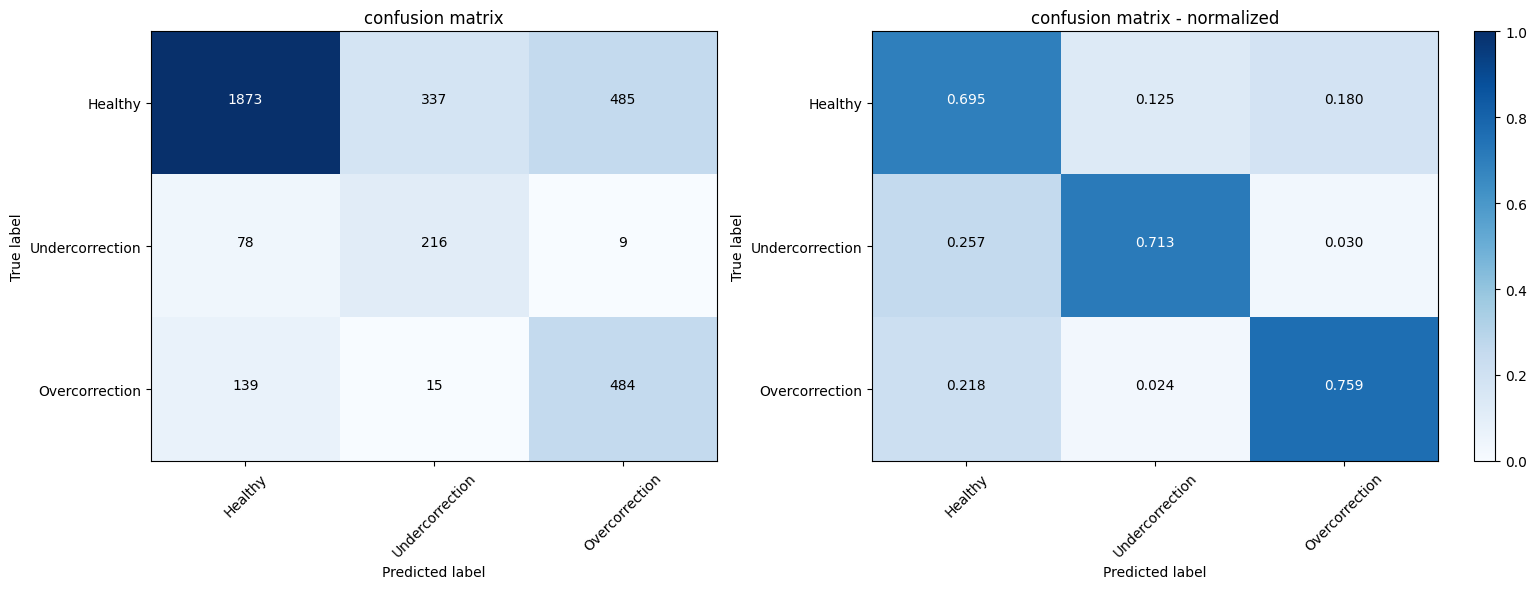

In [30]:
directory = '../../../'
df_pret = pd.DataFrame(data={'gt':gt, 'pred':pred})
# df_pret.to_csv(os.path.join(directory, 'box-level_prediction_3_classes.csv'))

print(classification_report(df_pret['gt'], df_pret['pred']))
report = classification_report(df_pret['gt'], df_pret['pred'], output_dict=True)
df_report = pd.DataFrame(report).transpose()
report_filename = os.path.join(directory, "box-level_report.csv")
# df_report.to_csv(report_filename)


class_names = ['Healthy', 'Undercorrection', 'Overcorrection']
# class_names = ['Healthy', 'Bad']

fig = plt.figure(figsize=(16,6))
plt.subplot(121)
cnf_matrix = confusion_matrix(df_pret['gt'], df_pret['pred'])
specificity=specificity_macro(cnf_matrix)

print(f"specificity: {specificity:.4f}")


plot_confusion_matrix(cnf_matrix, classes=class_names, title='confusion matrix')
plt.subplot(122)
cm = plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='confusion matrix - normalized')
# plt.savefig(os.path.join(directory, 'box-level_cm.png'),dpi=200)

## Eye level evaluation

-1 indicates a conflict: same number of labels for either Entropion or Overcorrection
no conflicting label in the ground truth annotations --> good

In [ ]:
# df_eval = pd.DataFrame(data={'cid':lcid, 'eye':leye, 'dataset':datasets, 'gt':gt_eye, 'pred':pred_eye})

In [ ]:
# df_outcomes = pd.read_csv('/CMF/data/lumargot/trachoma/mtss_pret_all_outcomes_combined.csv')
# df_eval['12month_outcomes'] = 0

# l_outcomes = []
# for idx, row in df_eval.iterrows():
#   cid, eye = row['cid'], row['eye']

#   df_i = df_outcomes.loc[ (df_outcomes['cid'] == int(cid)) & (df_outcomes['eye'] == eye.upper())]
#   isECA, isTT = df_i.iloc[0]['ECA'], df_i.iloc[0]['PTT']
#   outcome = 1
#   if isECA == 1 and isTT ==1:
#     outcome = -1
#   elif isECA == 1:
#     outcome = 3
#   elif isTT == 1: 
#     outcome = 2
#   l_outcomes.append(outcome)
# df_eval['12month_outcomes'] = l_outcomes
# df_sel = df_eval

In [ ]:
# df_eval.to_csv('/CMF/data/lumargot/trachoma/prediction_model.csv')

In [ ]:
# df_sel = df_eval
# df_sel = df_eval.loc[ df_eval['gt'] != -1]
# df_sel = df_sel.loc[ df_sel['pred'] != -1]

In [ ]:
directory = '../../../'

In [ ]:
# class_names = ['Healthy', 'Entropion', 'Overcorrection']

# print(classification_report(df_sel['gt'], df_sel['pred']))

# report = classification_report(df_sel['gt'], df_sel['pred'], output_dict=True)
# df_report = pd.DataFrame(report).transpose()
# report_filename = os.path.join(directory, "eye-level_report_3_classes_mtss.csv")
# df_report.to_csv(report_filename)


# fig = plt.figure(figsize=(16,6))
# plt.subplot(121)
# cnf_matrix = confusion_matrix(df_sel['gt'], df_sel['pred'])
# plot_confusion_matrix(cnf_matrix, classes=class_names, title='confusion matrix')

# plt.subplot(122)
# cm = plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='confusion matrix - normalized')
# plt.savefig(os.path.join(directory, 'eye-level_cm_3_classes_mtss.png'), dpi=200)

## Box level 

              precision    recall  f1-score   support

           1       0.85      0.82      0.83      2819
           2       0.42      0.72      0.53       310
           3       0.62      0.54      0.58       691

    accuracy                           0.76      3820
   macro avg       0.63      0.69      0.65      3820
weighted avg       0.78      0.76      0.76      3820

Confusion matrix, without normalization
Normalized confusion matrix, avg: 0.6903602937063619


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


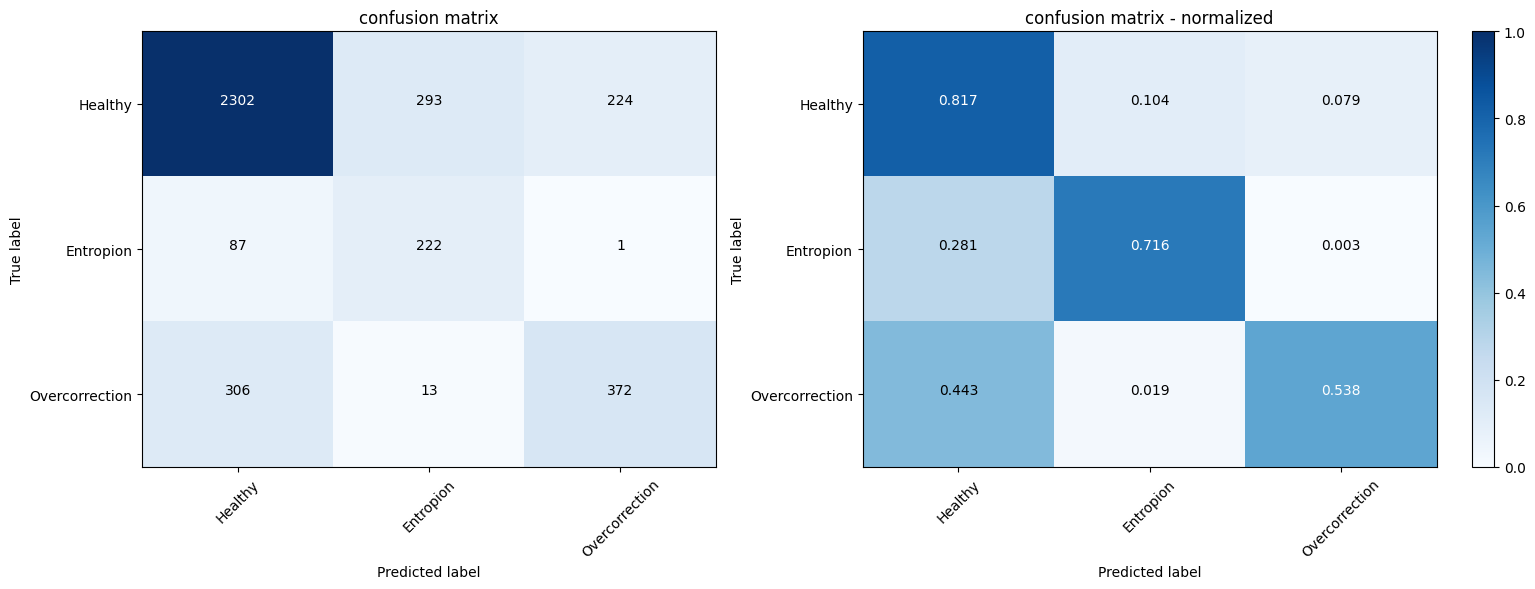

## Visualization

In [ ]:
def plot_patches(img, targets, map, title='ground truth'):
  ax = plt.gca()
  ax.imshow(img)
  ax.set_title(title)

  boxes = targets['boxes']
  labels = targets['labels']

  for j in range(labels.shape[0]):
    box = boxes[j]
    label = labels[j]

    x1, y1, x2, y2 = box
    width, height = x2 - x1, y2 - y1
    color = np.array(colormap[map[label.item()]])/255

    rect = Rectangle((x1, y1), width, height, fill=False, color=color, linewidth=1.5)
    ax.add_patch(rect)

    if 'scores' in targets.keys():
      score = targets['scores'][j]
      ax.text(x1, y1-100, f'{score:.2f}', color='red')

In [ ]:
preds['boxes'].shape

(9, 4)

  0%|          | 0/342 [00:00<?, ?it/s]

B images one eye/img/1009_B-LEFT.jpg
2 3


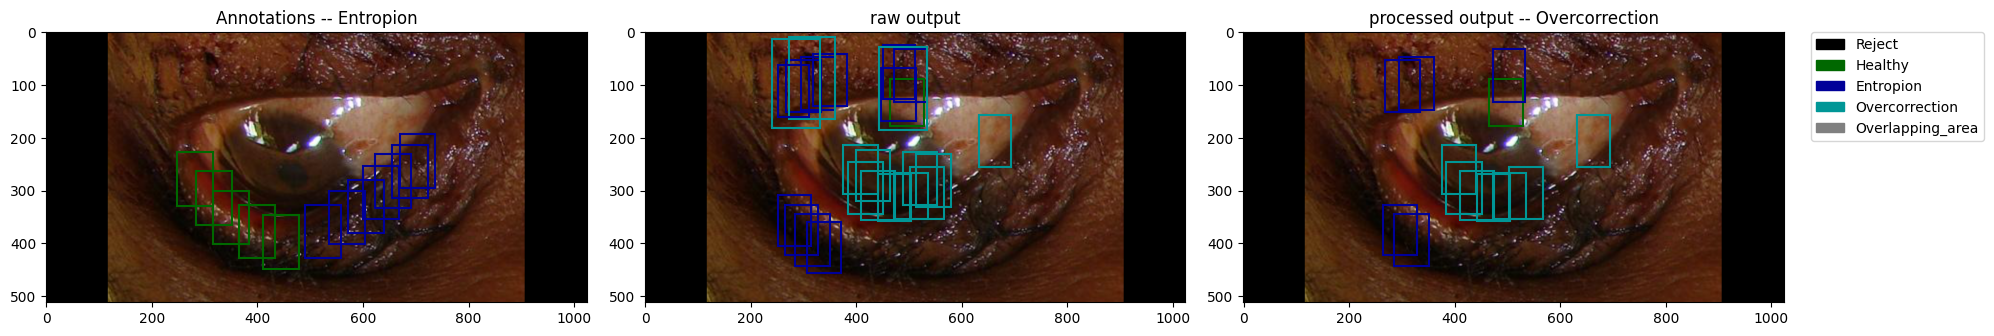

  0%|          | 1/342 [00:00<04:20,  1.31it/s]

B images one eye/img/1021_B-LEFT.jpg
1 1


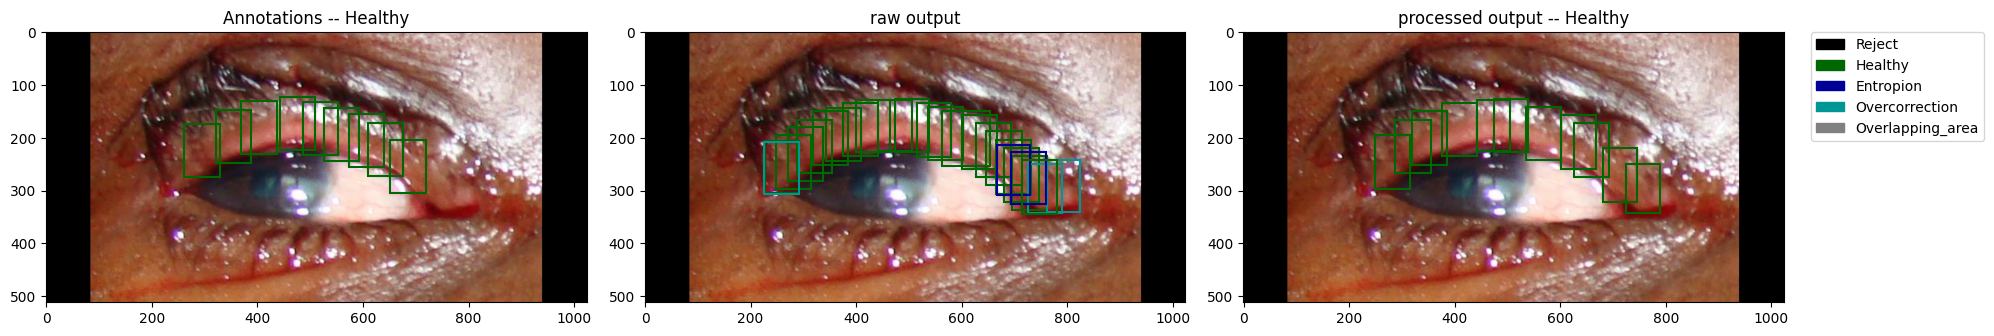

  1%|          | 2/342 [00:01<03:53,  1.45it/s]

B images one eye/img/1021_B1-LEFT.jpg
1 3


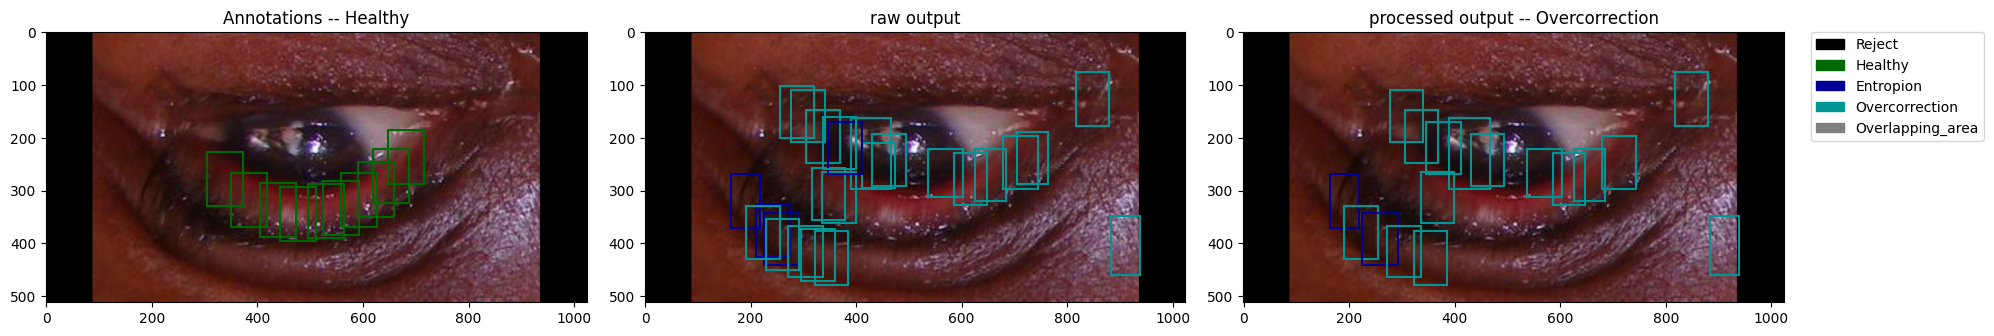

  1%|          | 2/342 [00:02<05:42,  1.01s/it]


In [ ]:
out_dir = '/CMF/data/lumargot/trachoma/output/tmp2/'
model.eval()

for IDX, batch in enumerate(tqdm(dataload)):
  if IDX <0:
    pass
  else:
    # try: 
    targets = batch
    imgs = targets.pop('img', None)
    # _ = targets.pop('severity', None)
    outs = model(imgs, mode='test')
    out_img = outs[0]

    img = imgs[0].permute(1,2,0)
    eyelid_seg = select_eyelid_seg(targets['mask'][0])
    
    ## targets
    for k in targets.keys():
      targets[k] = targets[k].squeeze(0).cpu().detach()

    # gt_indices = nms(targets['boxes'][0], torch.ones_like(targets['boxes'][0,:,0]), iou_threshold=1.0) ## iou as args
    # gt_indices = custom_x_nms(targets, iou_thresh=0.5)

    targets = convert_targets_numpy(targets) 
    # targets = filter_targets_indices(targets, gt_indices)
    map_outcome = {-1:'Conflict', 1:'Healthy', 2:'Entropion', 3:'Overcorrection'}
    gt_outcome = gt_eye_outcome(targets['labels'])    

    filename = dataload.dataset.data.df_subject.iloc[IDX]['filename']

    print(filename)
    ## predictions 
    preds = filter_indices_on_segmentation_mask(eyelid_seg, out_img, overlap_threshold=0.6)
    out_img = convert_targets_numpy(out_img)

    filled_preds = process_predictions(preds)
    thr = filled_preds['scores'].mean() - 2*filled_preds['scores'].std()
    keep = filled_preds['scores'] > thr
    filled_preds = filter_targets_indices(filled_preds, keep)
    processed_outcome = eye_level_outcome(filled_preds, img.shape)

    print(gt_outcome, processed_outcome)
    
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plot_patches(img, targets, map=map, title=f'Annotations -- {map_outcome[gt_outcome]}')

    plt.subplot(132)
    plot_patches(img, out_img, map=map, title=f'raw output')

    plt.subplot(133)
    legend_patches = [mpatches.Patch(color=np.array(color)/255, label=name) for name, color in colormap.items()]
    plot_patches(img, filled_preds, map=map, title=f'processed output -- {map_outcome[processed_outcome]}')
    plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()

    # overlay, masked_overlay = create_mask(eyelid_seg, filled_preds)
    # result = add_mask_countours(img, overlay)    
    # plt.imshow(result)
    # plt.title(f"post-processing --  {map_outcome[outcome]}")
    # plt.tight_layout()

    plt.show()
    filepath = os.path.join(out_dir, os.path.basename(filename).replace('.jpg', '.png'))
    # plt.savefig(filepath,dpi=200)
    plt.close()

  if  IDX ==2:
    break

In [ ]:
## predictions 
plt.figure(figsize=(20,10))
plt.figure(figsize=(20,10))

preds_1 = filter_indices_on_segmentation_mask(eyelid_seg, out_img, overlap_threshold=0.6)

original_preds = {}
for k in preds_1.keys():
  original_preds[k] = preds_1[k]
  preds_1[k] = torch.tensor(preds_1[k])


keep = preds_1['scores'] > 0.1
preds2 = filter_targets_indices(preds_1, keep, detach=False)

pred_indices = custom_x_nms(preds2, iou_thresh=0.4)
preds2 = filter_targets_indices(preds2, pred_indices, detach=True)
plt.subplot(121)
plot_patches(img, preds2, map=map, title=f'before filtering')
preds3 = fill_empty_patches(preds2)
preds3 = replace_sandwiched_labels(preds3)
plt.subplot(122)
plot_patches(img, preds3, map=map, title=f'after filtering')
plt.savefig('replace_patche.png', dpi=200)

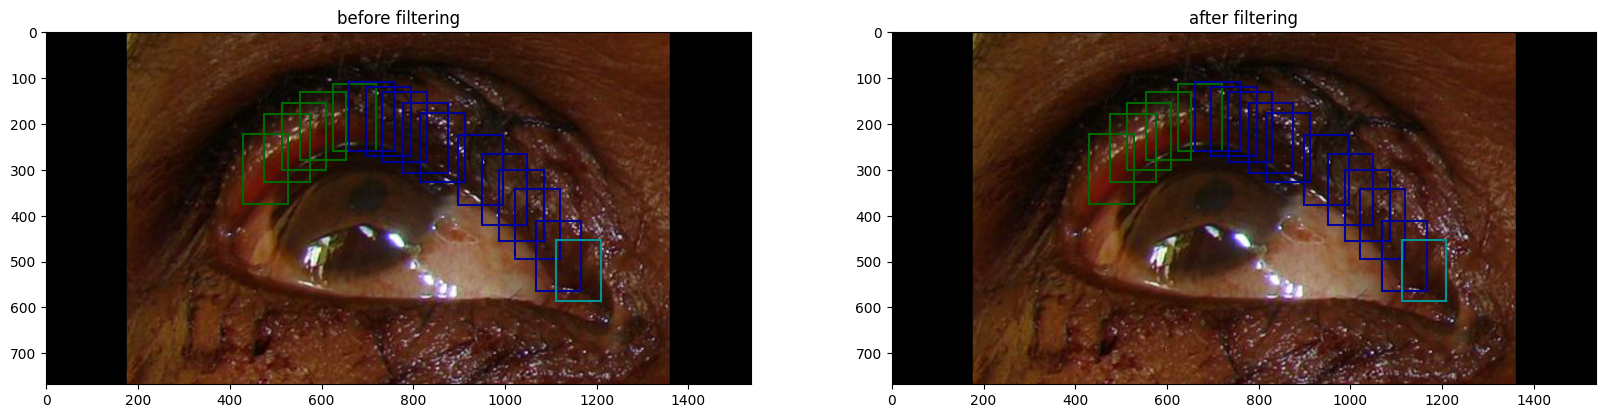

In [ ]:
# out_img = convert_targets_numpy(out_img)
# preds = filter_indices_on_segmentation_mask(eyelid_seg, out_img, overlap_threshold=0.6)




In [ ]:
def replace_sandwiched_labels(targets, context_width=2):    
  targets = sort_values(targets)
  for k in targets.keys():
    targets[k] = targets[k].numpy()
  boxes = targets['boxes']
  labels = targets['labels']

  updated_labels = labels.copy()
  updated_boxes = boxes.copy()

  delta_idx = 0
  for i in range(len(labels)):
    left_context = labels[max(0, i-context_width):i]
    right_context = labels[i+1:min(len(labels), i+context_width+1)]
    current_label = labels[i]

    # Skip if either context is empty (One box: can't make a decision)
    # or handling for first box and last box of eyelid -> look at following/previous ones
    if len(left_context) == 0 or len(right_context) == 0:
      larger_context = context_width+1
      left_context = labels[max(0, i-larger_context):i]
      right_context = labels[i+1:min(len(labels), i+larger_context+1)]

      if len(left_context) == 0 and len(right_context) >= (larger_context): # 3 boxes needeed
          # First box
          if len(set(right_context)) == 1 and current_label != right_context[0]:
              updated_labels[i+delta_idx] = right_context[0]
      elif len(right_context) == 0 and len(left_context) >= (larger_context):# 3 boxes needeed
          # Last box
          if len(set(left_context)) == 1 and current_label != left_context[0]:
              updated_labels[i+delta_idx] = left_context[0]
      continue

    
    if (current_label not in left_context and current_label not in right_context):
      if (len(set(left_context)) == 1 and  len(set(right_context)) == 1): #only one label

        if (left_context[0] == right_context[0]): #left label == right label            

          # Replace the current label with the context label
          updated_labels[i+delta_idx] = left_context[0]
        
        else: # create 2 box of half width with each labels
          x1, y1, x2, y2 = boxes[i]
          xmi = x1 +(x2 -x1)/2

          updated_boxes = np.delete(updated_boxes,i+delta_idx, axis=0)
          updated_labels = np.delete(updated_labels,i+delta_idx)

          box_right = np.array([ xmi, y1, x2, y2], ndmin=2)
          updated_boxes = np.insert(updated_boxes, i+delta_idx, box_right, axis=0)
          updated_labels = np.insert(updated_labels, i+delta_idx, right_context[0], axis=0)

          box_left = np.array([ x1, y1, xmi, y2], ndmin=2)
          updated_boxes = np.insert(updated_boxes, i+delta_idx, box_left, axis=0)
          updated_labels = np.insert(updated_labels, i+delta_idx, left_context[0], axis=0)
          
          if 'scores' in targets:
            scores = targets['scores']
            targets['scores'] = np.insert(scores, i+delta_idx, scores[i+delta_idx], axis=0)

          delta_idx +=1

  targets['boxes'] = updated_boxes
  targets['labels'] = updated_labels
  return targets
